In [9]:
import pandas as pd
import numpy as np
from copy import deepcopy
from glob import glob
import os
import os.path as op
import random
from sklearn.preprocessing import StandardScaler
from mixed_sigmoid_normalisation import MixedSigmoidScaler,mixed_sigmoid_func

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.preprocessing import compute_proj_ecg, compute_proj_eog
import mne_connectivity
from mne_connectivity import envelope_correlation

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [11]:
# Define data directory
github_repo_dir = "/Users/abry4213/github/info_theory_visuals"
data_dir = f"{github_repo_dir}/data"

# Define configuration file
infotheory_config_file = f"{data_dir}/infotheory_measures.yaml"

# Load SPI groupings
infotheory_measure_info = pd.read_csv(f"{data_dir}/infotheory_measure_info.csv")

MEG_resting_1min_infotheory_res = pd.read_csv(f"{data_dir}/MEG_Resting_State_Epoch_1min_infotheory_measures.csv").merge(infotheory_measure_info, on="Measure", how='left')

In [12]:
MEG_resting_1min_infotheory_res

,Measure,region_from,region_to,Measure_Type,value,Base_Region,Measure_name,Group,Group_number
0,entropy_kozachenko,lateraloccipital,lateraloccipital,Univariate,1.442819,lateraloccipital,Entropy,Univariate order-independent,1
1,AIS_kraskov,lateraloccipital,lateraloccipital,Univariate,0.029170,lateraloccipital,Active information storage,Univariate order-dependent,4
2,entropy_kozachenko,parahippocampal,parahippocampal,Univariate,1.441572,parahippocampal,Entropy,Univariate order-independent,1
3,AIS_kraskov,parahippocampal,parahippocampal,Univariate,0.026451,parahippocampal,Active information storage,Univariate order-dependent,4
4,je_kozachenko,lateraloccipital,parahippocampal,Bivariate,2.878938,NaN,Joint entropy,"Bivariate order-independent, undirected",2
...,...,...,...,...,...,...,...,...,...
360,di_kozachenko,lateraloccipital,temporalpole,Bivariate,2.299598,NaN,Directed information,"Bivariate order-dependent, directed",6
361,gc_gaussian_k-1_kt-1_l-1_lt-1,lateraloccipital,temporalpole,Bivariate,0.000016,NaN,Granger causality,"Bivariate order-dependent, directed",6
362,te_kraskov_NN-4_k-1_kt-1_l-1_lt-1,lateraloccipital,temporalpole,Bivariate,-0.006050,NaN,Transfer entropy,"Bivariate order-dependent, directed",6
363,ce_kozachenko,lateraloccipital,temporalpole,Bivariate,1.415613,NaN,Conditional entropy,"Bivariate order-independent, directed",3


`summarise()` has grouped output by 'region_to', 'Measure_name'. You can
override using the `.groups` argument.
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning message:
In left_join(., as_tibble(dk)) :
  Detected an

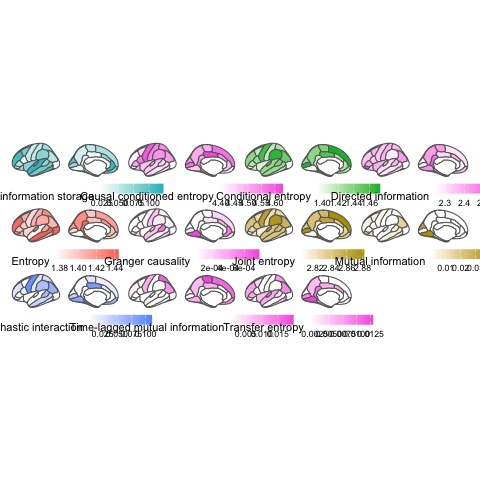

In [13]:
%%R -i MEG_resting_1min_infotheory_res -o mean_measure_value_by_region

# Generate default color palette
gg_color_hue <- function(n) {
      hues = seq(15, 375, length = n + 1)
      hcl(h = hues, l = 65, c = 100)[1:n]
      }
group_colors <- gg_color_hue(6)

# Let's plot this in the brain
mean_measure_value_by_region <- MEG_resting_1min_infotheory_res %>%
  group_by(region_to, Measure_name, Group_number) %>%
  summarise(mean_value = mean(value, na.rm=T)) %>%
  ungroup() %>%
  mutate(label = glue("lh_{region_to}"),
         mean_value = ifelse(mean_value<0, NA_real_, mean_value))
  
mean_measure_value_by_region_dk <- mean_measure_value_by_region %>%
  left_join(., as_tibble(dk))

plot_list <- list()
for (measure in unique(mean_measure_value_by_region_dk$Measure_name)) {
      this_measure_data <- subset(mean_measure_value_by_region_dk, Measure_name==measure)
      measure_group_color <- group_colors[this_measure_data$Group_number][1]
      p <- mean_measure_value_by_region_dk %>%
            filter(Measure_name==measure) %>%
            ggseg(atlas = dk, 
                  # mapping = aes(fill = mean_value_norm),
                  mapping=aes(fill=mean_value),
                  position = "stacked", colour = "gray40", hemisphere="left") +
            theme_void() +
            labs(fill = measure) +
            theme(plot.title = element_blank(),
                  legend.key.width = unit(0.45, "cm"),
                  legend.key.height = unit(0.35, "cm"),
                  legend.position = "bottom") +
            scale_fill_gradient(low="white", high=measure_group_color, na.value="white")
      plot_list[[measure]] <- p
}

wrap_plots(plot_list)
# ggsave("../SPIs/figure_drafting/info_theory_measures_in_brain_100_subjects.svg", width=10, height=5, units="in", dpi=300)